In [10]:
import torch
import numpy as np
import os
import random

In [2]:
DES_DIR = "/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles"
DES_BANDS = ("g", "r", "i", "z")
DES_SUBDIRS = [d for d in os.listdir(DES_DIR) if d.startswith("DES")]
tiles_per_img = 64

In [3]:
def convert_to_global_idx(tile_idx, gpu_idx):
    num_gpus = 2
    tiles_per_img = 64
    batch_size = 2
    dir_idx = int(num_gpus * (tile_idx // (tiles_per_img / batch_size)) + gpu_idx)
    subimage_idx = [(batch_size * tile_idx + i) % tiles_per_img for i in range(batch_size)]
    return dir_idx, subimage_idx

def convert_to_tile_idx(dir_idx):
    num_gpus = 2
    tiles_per_img = 64
    batch_size = 2
    gpu_idx = dir_idx % num_gpus
    tile_starting_idx = (tiles_per_img / batch_size) * (dir_idx // num_gpus)
    return int(tile_starting_idx), int(gpu_idx)

In [4]:
tile_idx = 0
gpu_idx = 0

dir_idx, subimage_idx = convert_to_global_idx(tile_idx, gpu_idx)
print(f"Directory: {DES_SUBDIRS[dir_idx]}")
print(f"Subimage: {subimage_idx}")

Directory: DES0053-2041
Subimage: [0, 1]


In [5]:
memberships = torch.empty((0,10,10))
output_dir = "/data/scratch/des/dr2_detection_output/run_0"
dir_idx = 10167
tile_starting_idx, gpu_idx = convert_to_tile_idx(dir_idx)
for tile in range(tile_starting_idx, tile_starting_idx + 32):
    file = torch.load(f"{output_dir}/tile_{tile}_gpu_{gpu_idx}.pt")
    memberships = torch.cat((memberships, file["mode_cat"]["membership"].squeeze()), dim=0)

expanded_memberships = torch.repeat_interleave(memberships, repeats=128, dim=1)
expanded_memberships = torch.repeat_interleave(expanded_memberships, repeats=128, dim=2)
expanded_memberships.shape

torch.Size([64, 1280, 1280])

In [34]:
# gpu 0 : 0, 2, 4, 6, 8, ...
# gpu 1 : 1, 3, 5, 7, 9, ...

# tile_0 : 0, 1             -- image 0
# tile_1 : 2, 3             -- image 0
# tile_2 : 4, 5             -- image 0
# ...
# tile_31 : 62, 63          -- image 0
# tile_32 : 64, 65          -- image 1 (image 2 overall)

# tile_t_gpu_g --> dir_id = 2 * (t // 32) + g
#              --> sub_id = (2*t % 64), (2*t + 1) % 64

500

In [9]:
def count_num_clusters(dir_idx):
    memberships = torch.empty((0,10,10))
    tile_starting_idx, gpu_idx = convert_to_tile_idx(dir_idx)
    for tile in range(tile_starting_idx, tile_starting_idx + 32):
        file = torch.load(f"{output_dir}/tile_{tile}_gpu_{gpu_idx}.pt")
        memberships = torch.cat((memberships, file["mode_cat"]["membership"].squeeze()), dim=0)
    memberships = torch.repeat_interleave(memberships, repeats=128, dim=1)
    memberships = torch.repeat_interleave(memberships, repeats=128, dim=2)
    return torch.any(memberships.view(memberships.shape[0], -1), dim=1).sum()

In [13]:
random_sample = random.sample(list(enumerate(DES_SUBDIRS)), 100)

In [14]:
num_clusters = {}
for dir_idx , dir in random_sample:
    num_clusters[dir] = count_num_clusters(dir_idx)

In [25]:
num_clusters_vals = list(num_clusters.values())

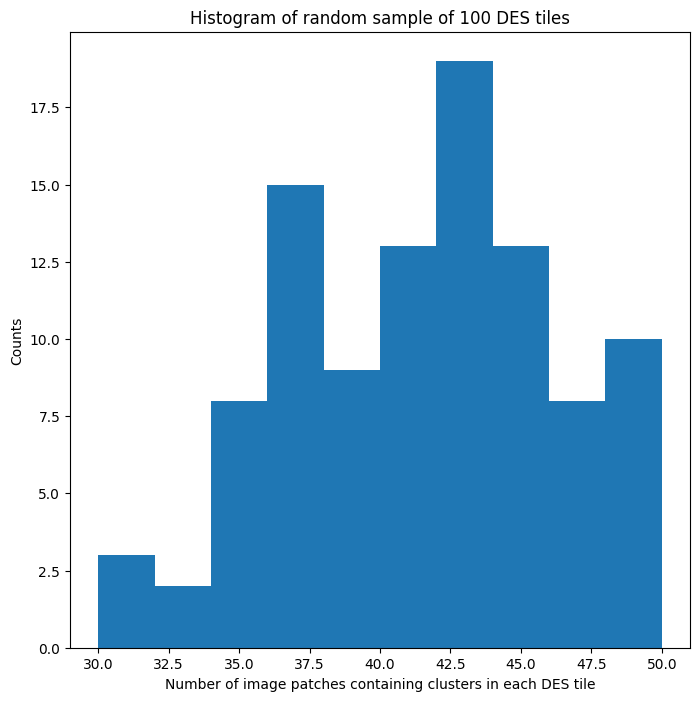

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.xlabel("Number of image patches containing clusters in each DES tile")
plt.ylabel("Counts")
plt.title("Histogram of random sample of 100 DES tiles")
plt.hist(num_clusters_vals)
plt.show()

In [32]:
np.array(num_clusters_vals).mean()

41.04